# Calculate the binodals of phase coexistence in the NRQS model

## Definition of chemical potential and quorum-sensing rules

The chemical potential of species $S$ reads
$$
\mu_S(\phi_A, \phi_B) = \ln [\phi_S v_S(\phi_A, \phi_B)],
$$
where
$$
v_S(\phi_A,\phi_B) = v_{SA}(\phi_A)v_{SB}(\phi_B),
$$
with
$$
\begin{aligned}
v_{SA}(\rho_A(\mathbf{r})) &= 1 + \kappa \tanh \left(
		\frac{\eta_{SA}}{\kappa}\frac{\rho_A(\mathbf{r})-\rho_0}{\rho_0}
	\right),\\
v_{SB}(\rho_B(\mathbf{r})) &= 1 + \kappa \tanh \left(
		\frac{\eta_{SB}}{\kappa}\frac{\rho_B(\mathbf{r})-\rho_0}{\rho_0}
	\right).
\end{aligned}
$$
The derivative of $v_{SS'}$ with respect to $\phi_{S'}$ reads
$$
\begin{aligned}
\tilde{v}_{SA}'(\rho_A)&=\partial_{\rho_A} v_{SA} = \frac{\eta_{SA}}{\rho_0} \left[1-\tanh^2 \left(\frac{\eta_{SA}}{\kappa}\frac{\rho_A-\bar{\rho}_A}{\rho_0}\right)\right] = \frac{\eta_{SA}}{\rho_0} \left[
    1 - \left(\frac{v_{SA}-1}{\kappa}\right)^2
\right],\\
\tilde{v}_{SB}'(\rho_B)&=\partial_{\rho_B} v_{SB} = \frac{\eta_{SB}}{\rho_0} \left[1-\tanh^2 \left(\frac{\eta_{SB}}{\kappa}\frac{\rho_B-\bar{\rho}_B}{\rho_0}\right)\right] = \frac{\eta_{SB}}{\rho_0} \left[
    1 - \left(\frac{v_{SB}-1}{\kappa}\right)^2
\right].
\end{aligned}
$$

In [112]:
import numpy as np
import matplotlib.pyplot as plt

def get_v_XY(rho_Y, eta_XY, kappa=0.7):
    return 1 + kappa * np.tanh(eta_XY/kappa * (rho_Y-1))

def get_v_A(rho_A, rho_B, eta_AA, eta_AB, kappa=0.7):
    v_AA = get_v_XY(rho_A, eta_AA, kappa)
    v_AB = get_v_XY(rho_B, eta_AB, kappa)
    return v_AA * v_AB

def get_v_B(rho_A, rho_B, eta_BA, eta_BB, kappa=0.7):
    v_BA = get_v_XY(rho_A, eta_BA, kappa)
    v_BB = get_v_XY(rho_B, eta_BB, kappa)
    return v_BA * v_BB

def get_dv_XY(v_XY, eta_XY, kappa=0.7):
    return eta_XY * (1 - ((v_XY-1)/kappa)**2)

def get_mu_A(rho_A, rho_B, eta_AA, eta_AB, kappa=0.7):
    v_A = get_v_A(rho_A, rho_B, eta_AA, eta_AB, kappa)
    return np.log(rho_A * v_A)

def get_mu_B(rho_A, rho_B, eta_BA, eta_BB, kappa=0.7):
    v_B = get_v_B(rho_A, rho_B, eta_BA, eta_BB, kappa)
    return np.log(rho_B * v_B)

## Condition for phase coexistence

For the coexisting of liquid and gas phases, we need
$$
\begin{align*}
\mu_A(\phi_A^l,\phi_B^l) - \mu_A(\phi_A^g, \phi_B^g) &= 0, \\
\mu_B(\phi_A^l,\phi_B^l) - \mu_B(\phi_A^g, \phi_B^g) &= 0, \\
 \left.R_A R_B\right|_g^l + \int_{\phi_A^g}^{\phi_A^l}\mathrm{d}\phi_A\left(\frac{1}{\phi_A}+\frac{v_{AA}'}{v_{AA}}\right)R_A +
\int_{\phi_B^g}^{\phi_B^l}\mathrm{d}\phi_B\left(\frac{1}{\phi_B}+\frac{v_{BB}'}{v_{BB}}\right)R_B &= 0,
\end{align*},
$$
where
$$
R_A(\phi_A) = \ln v_{BA}(\phi_A),\\
R_B(\phi_B) = \ln v_{AB}(\phi_B).
$$


In [113]:
from scipy import integrate, optimize

def f_int_A(phi_A, eta_AA, eta_BA):
    v_AA = get_v_XY(phi_A, eta_AA)
    v_BA = get_v_XY(phi_A, eta_BA)
    v_AA_prime = get_dv_XY(v_AA, eta_AA)
    return (1/phi_A + v_AA_prime/v_AA) * np.log(v_BA)


def f_int_B(phi_B, eta_AB, eta_BB):
    v_AB = get_v_XY(phi_B, eta_AB)
    v_BB = get_v_XY(phi_B, eta_BB)
    v_BB_prime = get_dv_XY(v_BB, eta_BB)
    return (1/phi_B + v_BB_prime/v_BB) * np.log(v_AB)

def get_RA_RB(phi_A, phi_B, eta_BA, eta_AB):
    v_BA = get_v_XY(phi_A, eta_BA)
    v_AB = get_v_XY(phi_B, eta_AB)
    return np.log(v_BA) * np.log(v_AB)


def func(phi_arr, eta_AA, eta_AB, eta_BA, eta_BB):
    """ When phase equilibrium is reached, one should have [f1, f2, f3] = [0, 0, 0]

    Args:
        phi_arr (array): [phi_A_g, phi_B_g, phi_A_l, phi_B_l]
        eta_AA (float): _description_
        eta_AB (float): _description_
        eta_BA (float): _description_
        eta_BB (float): _description_
    """
    phi_A_g, phi_B_g, phi_A_l, phi_B_l = phi_arr
    f1 = get_mu_A(phi_A_l, phi_B_l, eta_AA, eta_AB) - get_mu_A(phi_A_g, phi_B_g, eta_AA, eta_AB)
    f2 = get_mu_B(phi_A_l, phi_B_l, eta_BA, eta_BB) - get_mu_B(phi_A_g, phi_B_g, eta_BA, eta_BB)

    int_A = integrate.quad(f_int_A, phi_A_g, phi_A_l, args=(eta_AA, eta_BA))
    int_B = integrate.quad(f_int_B, phi_B_g, phi_B_l, args=(eta_AB, eta_BB))
    f3 = get_RA_RB(phi_A_l, phi_B_l, eta_BA, eta_AB) - get_RA_RB(phi_A_g, phi_B_g, eta_BA, eta_AB) + int_A + int_B
    return [f1, f2, f3]

def func2(x_arr, eta_AA, eta_AB, eta_BA, eta_BB, rhoA_0, rhoB_0):
    """ When phase equilibrium is reached, one should have [f1, f2, f3, f4, f5] = [0, 0, 0, 0, 0]

    Args:
        phi_arr (array): [phi_A_g, phi_B_g, phi_A_l, phi_B_l, s]
        eta_AA (float): _description_
        eta_AB (float): _description_
        eta_BA (float): _description_
        eta_BB (float): _description_
    """
    phi_A_g, phi_B_g, phi_A_l, phi_B_l, s = x_arr
    f1 = get_mu_A(phi_A_l, phi_B_l, eta_AA, eta_AB) - get_mu_A(phi_A_g, phi_B_g, eta_AA, eta_AB)
    f2 = get_mu_B(phi_A_l, phi_B_l, eta_BA, eta_BB) - get_mu_B(phi_A_g, phi_B_g, eta_BA, eta_BB)

    int_A, err = integrate.quad(f_int_A, phi_A_g, phi_A_l, args=(eta_AA, eta_BA))
    int_B, err = integrate.quad(f_int_B, phi_B_g, phi_B_l, args=(eta_AB, eta_BB))
    f3 = get_RA_RB(phi_A_l, phi_B_l, eta_BA, eta_AB) - get_RA_RB(phi_A_g, phi_B_g, eta_BA, eta_AB) + int_A + int_B

    f4 = (1-s) * phi_A_g + s * phi_A_l - rhoA_0
    f5 = (1-s) * phi_B_g + s * phi_B_l - rhoB_0
    return [f1, f2, f3, f4, f5]

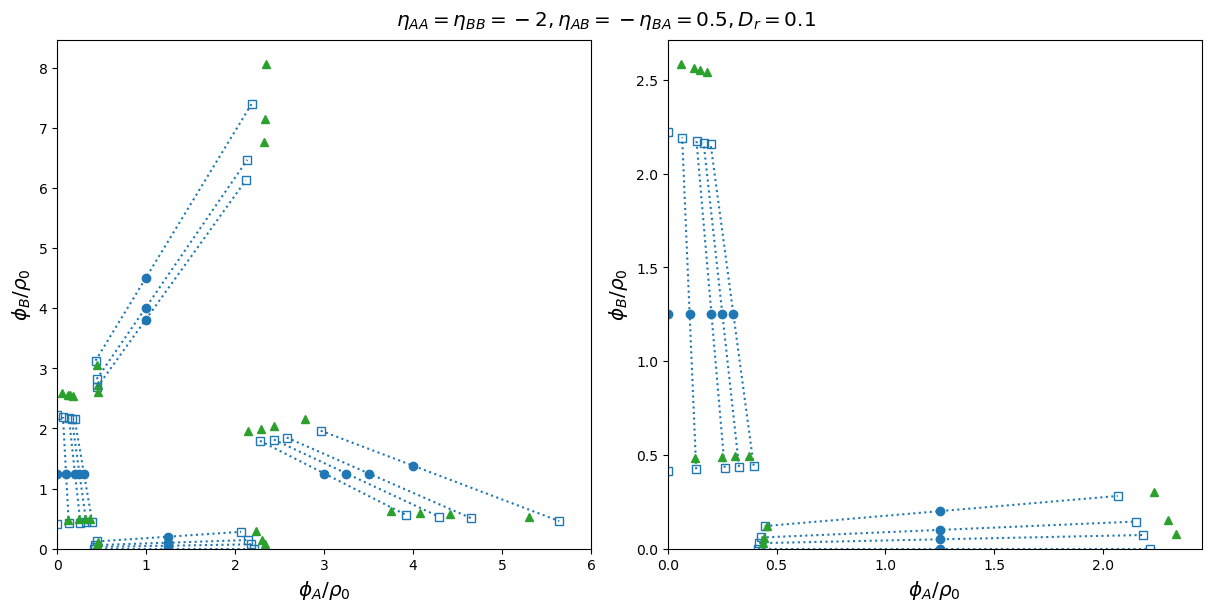

In [114]:
etaAA = -2
etaBB = -2
etaAB = 0.5
etaBA = -etaAB

# G + LA
center_G_LA = np.array([
        [12.5, 0],
        [12.5, 0.5],
        [12.5, 1],
        [12.5, 2],
        # [12.5, 3]
    ]) / 10
edge_G_LA = np.array([
        [[4.1229, 0], [22.1689, 0]],
        [[4.1984, 0.2967], [21.8290, 0.7313]],
        [[4.2891, 0.5983], [21.5045, 1.4470]],
        [[4.4534, 1.2062], [20.6741, 2.8125]],
        # [[4.6308, 1.7986], [19.6164, 4.1027]]
]) / 10


fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 6))
for i in range(edge_G_LA.shape[0]):
    center = center_G_LA[i]
    rho_g, rho_l = edge_G_LA[i]
    line, = ax1.plot(center[0], center[1], "o", c="tab:blue")
    ax1.plot([rho_g[0], rho_l[0]], [rho_g[1], rho_l[1]], ":", c=line.get_c())
    ax1.plot([rho_g[0], rho_l[0]], [rho_g[1], rho_l[1]], "s", fillstyle="none", c=line.get_c())

    line, = ax2.plot(center[0], center[1], "o", c="tab:blue")
    ax2.plot([rho_g[0], rho_l[0]], [rho_g[1], rho_l[1]], ":", c=line.get_c())
    ax2.plot([rho_g[0], rho_l[0]], [rho_g[1], rho_l[1]], "s", fillstyle="none", c=line.get_c())

    if i > 0:
        x0 = [rho_g[0], rho_g[1], rho_l[0], rho_l[1], 0.5]
        sol = optimize.root(func2, x0, args=(etaAA, etaAB, etaBA, etaBB, center[0], center[1]))
        x = sol.x
        ax1.plot([x[0], x[2]], [x[1], x[3]], "^", c="tab:green")
        ax2.plot([x[0], x[2]], [x[1], x[3]], "^", c="tab:green")


center_G_LB = np.array([[0, 12.5], [1, 12.5], [2, 12.5], [2.5, 12.5], [3, 12.5]]) / 10
edge_G_LB = np.array([
        [[0, 4.1531], [0, 22.1902]],
        [[1.3039, 4.2378], [0.6576, 21.9206]],
        [[2.6128, 4.3159], [1.3177, 21.7441]],
        [[3.2733, 4.3624], [1.6440, 21.6433]],
        [[3.9437, 4.4311], [1.9665, 21.5689]]
    ]) / 10
for i in range(edge_G_LB.shape[0]):
    center = center_G_LB[i]
    rho_g, rho_l = edge_G_LB[i]
    line, = ax1.plot(center[0], center[1], "o", c="tab:blue")
    ax1.plot([rho_g[0], rho_l[0]], [rho_g[1], rho_l[1]], ":", c=line.get_c())
    ax1.plot([rho_g[0], rho_l[0]], [rho_g[1], rho_l[1]], "s", fillstyle="none", c=line.get_c())

    line, = ax2.plot(center[0], center[1], "o", c="tab:blue")
    ax2.plot([rho_g[0], rho_l[0]], [rho_g[1], rho_l[1]], ":", c=line.get_c())
    ax2.plot([rho_g[0], rho_l[0]], [rho_g[1], rho_l[1]], "s", fillstyle="none", c=line.get_c())

    if i > 0:
        x0 = [rho_g[0], rho_g[1], rho_l[0], rho_l[1], 0.5]
        sol = optimize.root(func2, x0, args=(etaAA, etaAB, etaBA, etaBB, center[0], center[1]))
        x = sol.x
        ax1.plot([x[0], x[2]], [x[1], x[3]], "^", c="tab:green")
        ax2.plot([x[0], x[2]], [x[1], x[3]], "^", c="tab:green")


center_LB_LAB = np.array([[10, 45], [10, 40], [10, 38]]) / 10
edge_LB_LAB = np.array([
    [[4.3168, 31.2870], [21.8533, 73.9867]],
    [[4.4412, 28.2210], [21.3746, 64.7041]],
    [[4.5254, 26.9304], [21.2044, 61.2696]]
]) / 10

for i in range(edge_LB_LAB.shape[0]):
    center = center_LB_LAB[i]
    rho_g, rho_l = edge_LB_LAB[i]
    line, = ax1.plot(center[0], center[1], "o", c="tab:blue")
    ax1.plot([rho_g[0], rho_l[0]], [rho_g[1], rho_l[1]], ":", c=line.get_c())
    ax1.plot([rho_g[0], rho_l[0]], [rho_g[1], rho_l[1]], "s", fillstyle="none", c=line.get_c())

    if i > -1:
        x0 = [rho_g[0], rho_g[1], rho_l[0], rho_l[1], 0.5]
        sol = optimize.root(func2, x0, args=(etaAA, etaAB, etaBA, etaBB, center[0], center[1]))
        x = sol.x
        ax1.plot([x[0], x[2]], [x[1], x[3]], "^", c="tab:green")


# LAB + LA
center_LAB_LA = np.array([
    # [130/4, 40/4],
    [120/4, 50/4],
    [130/4, 50/4],
    [140/4, 50/4],
    [160/4, 55/4],
    # [45, 15],
    # [47, 19],
    # [60, 20]
    ]) / 10
edge_LAB_LA = np.array([
    # [[90.3333/4, 70.2929/4], [152.7865/4, 22.8993/4]],
    [[91.1910/4, 71.7885/4], [156.7620/4, 22.5345/4]], 
    [[97.4319/4, 72.6223/4], [171.5426/4, 21.3663/4]],
    [[103.2168/4, 73.9762/4], [185.9900/4, 20.3843/4]],
    [[118.4965/4, 78.5602/4], [225.7040/4, 18.3693/4]],
    # [[36.65, 19.], [66.4, 4.578]],
    # [[41.6492, 21.3472], [88.2805, 4.2819]],
    # [[53.6089, 22.2076], [108.7682, 4.1077]]
]) / 10

for i in range(edge_LAB_LA.shape[0]):
    center = center_LAB_LA[i]
    rho_g, rho_l = edge_LAB_LA[i]
    line, = ax1.plot(center[0], center[1], "o", c="tab:blue")
    ax1.plot([rho_g[0], rho_l[0]], [rho_g[1], rho_l[1]], ":", c=line.get_c())
    ax1.plot([rho_g[0], rho_l[0]], [rho_g[1], rho_l[1]], "s", fillstyle="none", c=line.get_c())

    if i > -1:
        x0 = [rho_g[0], rho_g[1], rho_l[0], rho_l[1], 0.5]
        sol = optimize.root(func2, x0, args=(etaAA, etaAB, etaBA, etaBB, center[0], center[1]))
        x = sol.x
        ax1.plot([x[0], x[2]], [x[1], x[3]], "^", c="tab:green")
        # ax.plot([x[0], x[2]], [x[1], x[3]], ":", c="tab:green")


ax1.set_xlim(0, 6)
ax1.set_ylim(0)
ax2.set_xlim(0)
ax2.set_ylim(0)
ax1.set_xlabel(r"$\phi_A/\rho_0$", fontsize="x-large")
ax1.set_ylabel(r"$\phi_B/\rho_0$", fontsize="x-large")
ax2.set_xlabel(r"$\phi_A/\rho_0$", fontsize="x-large")
ax2.set_ylabel(r"$\phi_B/\rho_0$", fontsize='x-large')

fig.suptitle(r"$\eta_{AA}=\eta_{BB}=-2, \eta_{AB}=-\eta_{BA}=0.5, D_r=0.1$", fontsize="x-large")
plt.show()
plt.close()

